# Imprtação de bibliotecas

In [1]:
!pip3 install lightgbm

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from functools import partial
from shapely.geometry import box
from datetime import datetime
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from math import radians, cos, sin, asin, sqrt, atan2
import warnings
import numpy as np
from sklearn.preprocessing import StandardScaler

# PostGis config

In [3]:
user = "gis"
password = "password"
host = "localhost"
port = "5432"
database = "gis"

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")

# Parâmetros

In [8]:
linha_desejada = '232'                      
data_desejada_inicial = '2024-04-25'      
data_desejada_final = '2024-04-25'  

data_desejada= data_desejada_inicial

# Query

In [2205]:
query = f"""
SELECT
    ordem,
    linha,
    velocidade,
    datahora,
    ST_AsText(geom) AS wkt_geom
FROM onibus_rj
WHERE linha = '{linha_desejada}'
  AND datahora >= '{data_desejada_inicial} 00:00:00'
  AND datahora <  '{data_desejada_final} 23:59:59';
"""

df = pd.read_sql(query, engine)

# GeoDataFrame

In [2206]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['wkt_geom']), crs="EPSG:4326")

print(f"Total de pontos carregados para linha {linha_desejada} no dia {data_desejada}: {len(gdf)}")


Total de pontos carregados para linha 232 no dia 2024-04-25: 66267


## Plotagem

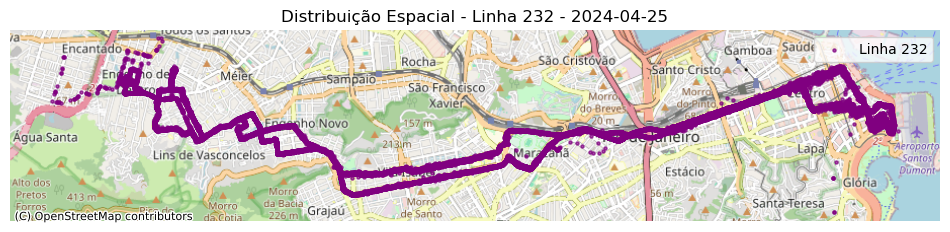

In [2207]:
fig, ax = plt.subplots(figsize=(12, 12))

# Reprojetar para Web Mercator (para o contextily funcionar)
gdf_webmercator = gdf.to_crs(epsg=3857)

# Plotar os pontos
gdf_webmercator.plot(ax=ax, color='purple', markersize=5, alpha=0.7, label=f'Linha {linha_desejada}')

# Adicionar mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Ajustes finais
plt.title(f"Distribuição Espacial - Linha {linha_desejada} - {data_desejada}")
ax.set_axis_off()
plt.legend()
plt.show()

## Visualizar apenas os pontos com velocidade zero (ônibus parados)

Total de pontos com velocidade zero: 25295


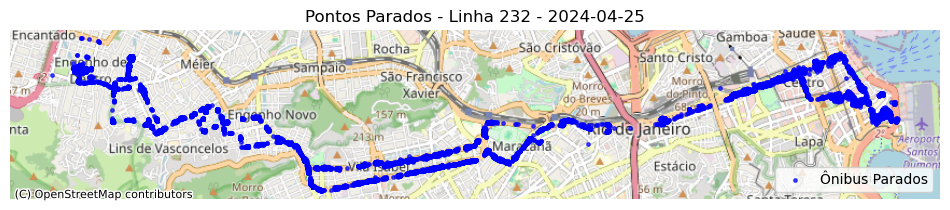

In [2208]:
# Filtrar os pontos parados
gdf_parados = gdf[gdf['velocidade'] == 0]
gdf_move    = gdf[gdf['velocidade'] != 0]

# Checar quantos pontos parados temos
print(f"Total de pontos com velocidade zero: {len(gdf_parados)}")

# Reprojetar para Web Mercator
gdf_parados_web = gdf_parados.to_crs(epsg=3857)

# Plotar
fig, ax = plt.subplots(figsize=(12, 12))
gdf_parados_web.plot(ax=ax, color='blue', markersize=6, alpha=0.7, label='Ônibus Parados')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title(f"Pontos Parados - Linha {linha_desejada} - {data_desejada}")
ax.set_axis_off()
plt.legend()
plt.show()

## Filtro de outlier

In [4]:
def filter_rush_hour(gdf):

    return gdf[
    (gdf['datahora'].dt.time >= pd.to_datetime("17:00").time()) &
    (gdf['datahora'].dt.time <= pd.to_datetime("19:00").time())
].copy()

In [5]:
gdf_sorted_full = gdf.sort_values('datahora').reset_index(drop=True)
#gdf_sorted = filter_rush_hour(gdf_sorted_full)
gdf_sorted = gdf_sorted_full

NameError: name 'gdf' is not defined

In [6]:
def get_one_bus(gdf):

    # 1. Identificar a primeira ordem
    primeira_ordem = gdf['ordem'].iloc[0]
    print(f"Usando apenas o ônibus de ordem: {primeira_ordem}")

    # 2. Filtrar os pontos apenas desse ônibus
    gdf_onibus = gdf[gdf['ordem'] == primeira_ordem].sort_values('datahora')

    return gdf_onibus

### Grid

In [31]:

# === Função para criar o grid ===
def create_grid(gdf, cell_size):
    bounds = gdf.total_bounds  # xmin, ymin, xmax, ymax
    xmin, ymin, xmax, ymax = bounds

    cols = np.arange(xmin, xmax + cell_size, cell_size)
    rows = np.arange(ymin, ymax + cell_size, cell_size)

    grid_cells = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            grid_cells.append(box(x, y, x + cell_size, y + cell_size))

    grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs)
    return grid

In [ ]:


# === Parâmetros do filtro ===
cell_size = 200  # Tamanho das células (em metros)
min_points = 10  # Número mínimo de pontos por célula

# === Reprojetar o GeoDataFrame para metros (EPSG:3857) ===
gdf_proj = gdf_sorted_full.to_crs(epsg=3857)

# === Criar o grid ===
grid = create_grid(gdf_proj, cell_size)

# === Spatial Join: Contar quantos pontos em cada célula ===
join = gpd.sjoin(gdf_proj, grid, how="left", predicate='within')
counts = join.groupby('index_right').size()
grid['n_points'] = counts
grid['n_points'] = grid['n_points'].fillna(0)

# === Filtrar células densas ===
valid_cells = grid.loc[grid['n_points'] >= min_points]

# === Filtrar apenas os pontos nas células válidas ===
final_gdf = gpd.sjoin(gdf_proj, valid_cells, how='inner', predicate='within')
final_gdf = final_gdf.drop(columns=['index_right'])

# === Reprojetar de volta para lon/lat (se quiser) ===
#final_gdf = final_gdf.to_crs(epsg=4326)

# === Resultado: final_gdf contém apenas os pontos em regiões densas ===
print(f"Número de pontos após o filtro por densidade: {len(final_gdf)}")


NameError: name 'gdf_sorted_full' is not defined

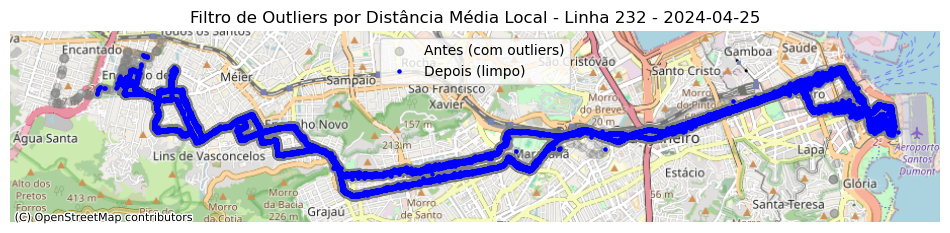

In [2213]:
fig, ax = plt.subplots(figsize=(12, 12))

gdf_sorted.to_crs(epsg=3857).plot(ax=ax, color='gray', alpha=0.3, label='Antes (com outliers)')
final_gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=5, label='Depois (limpo)')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title(f"Filtro de Outliers por Distância Média Local - Linha {linha_desejada} - {data_desejada}")
ax.set_axis_off()
plt.legend()
plt.show()

## Geração de trajetória

In [2214]:
gdf_onibus = get_one_bus(final_gdf)

Usando apenas o ônibus de ordem: B25523


In [2215]:
gdf_onibus

ordem linha  velocidade            datahora  \
0      B25523   232           0 2024-04-25 00:00:16   
29     B25523   232           0 2024-04-25 00:02:19   
53     B25523   232           0 2024-04-25 00:04:21   
71     B25523   232           0 2024-04-25 00:06:23   
85     B25523   232           0 2024-04-25 00:08:25   
...       ...   ...         ...                 ...   
66218  B25523   232           0 2024-04-25 23:53:57   
66231  B25523   232           0 2024-04-25 23:55:59   
66244  B25523   232           0 2024-04-25 23:57:41   
66248  B25523   232           0 2024-04-25 23:58:01   
66249  B25523   232           0 2024-04-25 23:58:01   

                         wkt_geom                           geometry  n_points  
0      POINT(-43.29764 -22.90253)  POINT (-4819871.237 -2620235.538)    2380.0  
29     POINT(-43.29763 -22.90253)  POINT (-4819870.124 -2620235.538)    2380.0  
53     POINT(-43.29763 -22.90251)  POINT (-4819870.124 -2620233.121)    2380.0  
71     POINT(-43.29763 -22.90249)  POINT (-4819870.124 -2620230.704)    2380.0  
85     POINT(-43.29764 -22.90248)  POINT (-4819871.237 -2620229.496)    2380.0  
...                           ...                                ...       ...  
66218  POINT(-43.29838 -22.90218)  POINT (-4819953.614 -2620193.242)    2380.0  
66231  POINT(-43.29838 -22.90218)  POINT (-4819953.614 -2620193.242)    2380.0  
66244  POINT(-43.29839 -22.90218)  POINT (-4819954.727 -2620193.242)    2380.0  
66248  POINT(-43.29839 -22.90218)  POINT (-4819954.727 -2620193.242)    2380.0  
66249  POINT(-43.29839 -22.90218)  POINT (-4819954.727 -2620193.242)    2380.0  

[2629 rows x 7 columns]

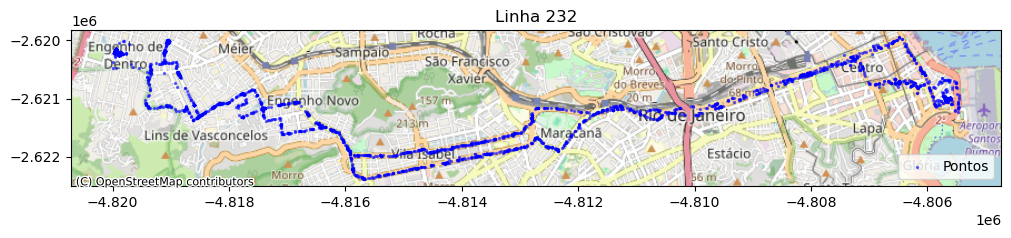

In [2216]:
# 6. Plotar
fig, ax = plt.subplots(figsize=(12, 12))
gdf_onibus.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=2, alpha=0.5, label='Pontos')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title(f'Linha {gdf_onibus["linha"].iloc[0]}')
plt.legend()
plt.show()

In [3]:
def get_coords(gdf):
    """
    Extrai as coordenadas de um GeoDataFrame e retorna uma lista de tuplas (lon, lat).
    """
    return [(point.x, point.y) for point in gdf.geometry]

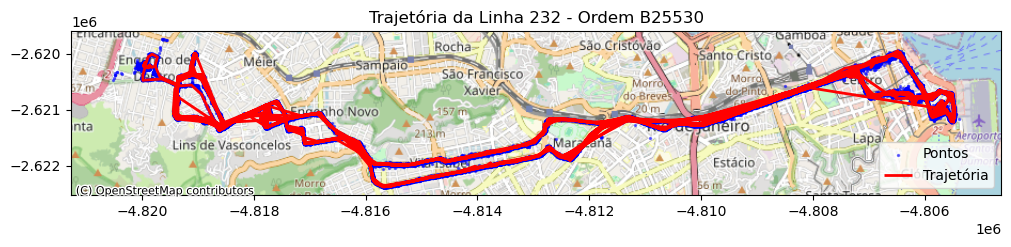

In [2217]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd



# 3. Criar a LineString (ainda em lon/lat)
coords = get_coords(gdf_onibus)
linha_trajeto = LineString(coords)

# 4. Criar GeoDataFrame da linha
trajeto_gdf = gpd.GeoDataFrame(geometry=[linha_trajeto], crs=gdf_onibus.crs)

# 6. Plotar
fig, ax = plt.subplots(figsize=(12, 12))
final_gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=2, alpha=0.5, label='Pontos')
trajeto_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', linewidth=2, label='Trajetória')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title(f'Trajetória da Linha {gdf_onibus["linha"].iloc[0]} - Ordem {primeira_ordem}')
plt.legend()
plt.show()



O caminho parece aceitável, validando o filtro em duas partes criado

## Função de remoção total de outlier:

In [28]:
def remove_outliers_grid(gdf, cell_size=200, min_points=10):
    """
    Remove outliers com base em um grid de densidade.
    """
    # Reprojetar para Web Mercator
    gdf_proj = gdf.to_crs(epsg=3857)

    # Criar o grid
    grid = create_grid(gdf_proj, cell_size)

    # === Spatial Join: Contar quantos pontos em cada célula ===
    join = gpd.sjoin(gdf_proj, grid, how="left", predicate='within')
    counts = join.groupby('index_right').size()
    grid['n_points'] = counts
    grid['n_points'] = grid['n_points'].fillna(0)

    # === Filtrar células densas ===
    valid_cells = grid.loc[grid['n_points'] >= min_points]

    # === Filtrar apenas os pontos nas células válidas ===
    final_gdf = gpd.sjoin(gdf_proj, valid_cells, how='inner', predicate='within')
    final_gdf = final_gdf.drop(columns=['index_right'])
        
    return final_gdf


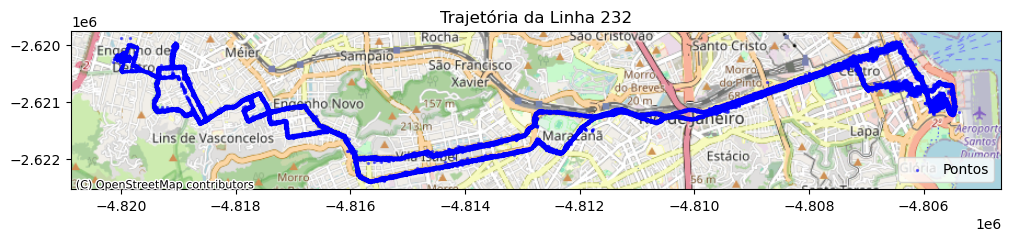

In [2219]:
gdf_grid_filtered = remove_outliers_grid(gdf, cell_size=150, min_points=10)
fig, ax = plt.subplots(figsize=(12, 12))
gdf_grid_filtered.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=2, alpha=0.5, label='Pontos')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title(f'Trajetória da Linha {gdf_grid_filtered["linha"].iloc[0]}')
plt.legend()
plt.show()

# Query função

In [7]:
linhas=['483', '864', '639', '3', '309', '774', '629', '371', '397', '100', '838', '315', '624', '388', '918', '665', '328', '497', '878', '355', '138', '606', '457', '550', '803', '917', '638', '2336', '399', '298', '867', '553', '565', '422', '756', '186012003', '292', '554', '634', '232', '415', '2803', '324', '852', '557', '759', '343', '779', '905', '108']

def select_data(engine,data_desejada_inicial, data_desejada_final, linhas=linhas):

	placeholders = ', '.join(f"'{linha}'" for linha in linhas)

	query = f"""
	SELECT
		ordem,
		linha,
		velocidade,
		datahora,
		ST_AsText(geom) AS wkt_geom
	FROM onibus_rj
	WHERE linha IN ({placeholders})
	AND datahora >= '{data_desejada_inicial} 00:00:00'
	AND datahora <  '{data_desejada_final} 23:59:59';
	"""

	df = pd.read_sql(query, engine)
	gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df['wkt_geom']), crs="EPSG:4326")

	return gdf.sort_values(by='datahora', ascending=True)

data_desejada_inicial = '2024-04-25'
data_desejada_final = '2024-05-11'	


gdf = select_data(engine,data_desejada_inicial, data_desejada_final, linhas=['483'])


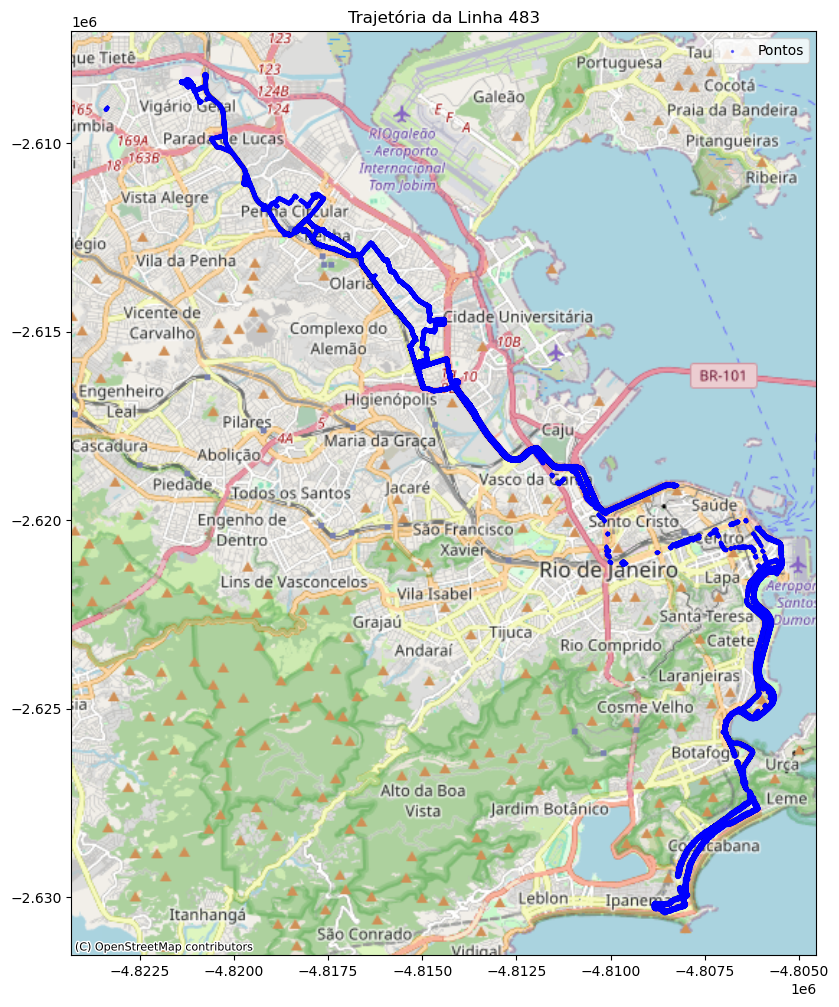

In [2358]:
gdf_grid_filtered = remove_outliers_grid(gdf, cell_size=50, min_points=50)
fig, ax = plt.subplots(figsize=(12, 12))
gdf_grid_filtered.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=2, alpha=0.5, label='Pontos')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title(f'Trajetória da Linha {gdf_grid_filtered["linha"].iloc[0]}')
plt.legend()
plt.show()

# Extração de Features

In [8]:
def extract_features_df(gdf, selected_features=['linha','velocidade', 'geometry', 'datahora']):
	gdf_features = gdf[selected_features]
	return gdf_features



In [63]:
def extract_coords_as_num_date(gdf_features):
    gdf_transf = gdf_features.reset_index(drop=True)

    # Extrai coordenadas numéricas
    gdf_transf['latitude'] = gdf_transf['geometry'].y
    gdf_transf['longitude'] = gdf_transf['geometry'].x

    # Cria features temporais adicionais (hora e dia da semana)
    gdf_transf['hour'] = gdf_transf['datahora'].dt.hour
    gdf_transf['day_of_week'] = gdf_transf['datahora'].dt.weekday
    gdf_transf['min'] = gdf_transf['datahora'].dt.minute
    gdf_transf['sec'] = gdf_transf['datahora'].dt.second
    gdf_transf['month'] = gdf_transf['datahora'].dt.month

    gdf_transf['lat_prev'] = gdf_transf.groupby(['ordem', 'linha'],observed=False)['latitude'].shift(1)
    gdf_transf['lon_prev'] = gdf_transf.groupby(['ordem', 'linha'],observed=False)['longitude'].shift(1)

    # Calcula delta_lat e delta_lon por ônibus e linha (para garantir que o cálculo não misture veículos nem linhas)
    gdf_transf['delta_lat'] = gdf_transf.groupby(['ordem', 'linha'],observed=False)['latitude'].diff()
    gdf_transf['delta_lon'] = gdf_transf.groupby(['ordem', 'linha'],observed=False)['longitude'].diff()

    # Converte datahora para número (timestamp em segundos)
    gdf_transf['datahora_num'] = gdf_transf['datahora'].astype('int64') // 10**9

    min_time = gdf_transf['datahora_num'].min()
    gdf_transf['horas_desde_inicio'] = (gdf_transf['datahora_num'] - min_time) / 3600

    # Remove geometria se quiser (mantendo datahora original e numérica)
    gdf_transf = gdf_transf.drop(columns='geometry')
        # Remove a coluna original 'linha' e 'ordem'
    gdf_transf = gdf_transf.drop(columns=['linha', 'ordem'])
    gdf_transf = gdf_transf.drop(columns=['n_points','wkt_geom'])
    gdf_transf = gdf_transf.drop(columns=['datahora'])

    gdf_transf = gdf_transf.dropna()

    return gdf_transf




In [10]:
def extract_coords_as_num(gdf_features):
    gdf_transf = gdf_features.reset_index(drop=True)

    # Extrai coordenadas numéricas
    gdf_transf['latitude'] = gdf_transf['geometry'].y
    gdf_transf['longitude'] = gdf_transf['geometry'].x

    gdf_transf = gdf_transf.drop(columns='geometry')

    return gdf_transf

In [11]:
def encoding_features(gdf_transf):
    # Converte 'linha' para categórica
    gdf_transf['linha'] = gdf_transf['linha'].astype('category')
    gdf_transf['ordem'] = gdf_transf['ordem'].astype('category')

    # Cria dummies para a coluna 'linha'
    dummies = pd.get_dummies(gdf_transf['linha'], prefix='linha', drop_first=True)
    dummies_ordem = pd.get_dummies(gdf_transf['ordem'], prefix='ordem', drop_first=True)

    # Concatena as dummies com o DataFrame original
    gdf_transf = pd.concat([gdf_transf, dummies], axis=1)
    gdf_transf = pd.concat([gdf_transf, dummies_ordem], axis=1)

    return gdf_transf

# Aplicação de modelos

## Test split

In [12]:


def split_test_task_date(gdf_transf):
	""" 
		Divide o dataset cronologicamente para prever datahora
	"""
	split_index = int(len(gdf_transf) * 0.8)
	cutoff_time = gdf_transf.loc[split_index, 'datahora']

	df_train = gdf_transf[gdf_transf['datahora'] <= cutoff_time]
	df_test = gdf_transf[gdf_transf['datahora'] > cutoff_time]

	features = ['longitude', 'latitude', 'velocidade']
	X_train = df_train[features]
	y_train = df_train['datahora']
	X_test = df_test[features]
	y_test = df_test['datahora']

	return X_train, y_train, X_test, y_test



In [43]:
def split_test_task_pos(gdf_transf,target=['longitude', 'latitude']):
	""" 
		Divide o dataset em treino e teste cronologicamente para prever posição
	"""
	split_index = int(len(gdf_transf) * 0.8)
	cutoff_time = gdf_transf.loc[split_index, 'datahora_num']

	df_train = gdf_transf[gdf_transf['datahora_num'] <= cutoff_time]
	df_test = gdf_transf[gdf_transf['datahora_num'] > cutoff_time]

	#if target != ['datahora']:
	#	df_train = df_train.drop(columns=['datahora_num'])
	#	df_test = df_test.drop(columns=['datahora_num'])

	features = [col for col in df_train.columns if col not in target]
	X_train = df_train[features]
	y_train = df_train[target]
	X_test = df_test[features]
	y_test = df_test[target]



	return X_train, y_train, X_test, y_test

In [73]:
def get_train(gdf_transf,target=['longitude', 'latitude']):
	""" 
        Extrai X_train do GeoDataFrame transformado
    """

	features = [col for col in gdf_transf.columns if col not in target]
	X_train = gdf_transf[features]
	y_train = gdf_transf[target]

	return X_train, y_train

In [74]:
def get_test(gdf_transf, target=['longitude', 'latitude']):
    """ 
        Extrai X_test do GeoDataFrame transformado
    """

    features = [col for col in gdf_transf.columns if col not in target] 
    X_test = gdf_transf[features]

    return X_test

## Cálculo de RMSE

In [14]:

def evaluate_rmsle(y_test, y_pred):
	y_pred = np.maximum(y_pred, 0)
	rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
	print(rmsle)



In [15]:
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Raio da Terra em metros
    phi1, phi2 = radians(lat1), radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)

    a = sin(delta_phi / 2.0)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2.0)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def evaluate_position_prediction_pos(y_true, y_pred):
    errors = []
    for (lat_t, lon_t), (lat_p, lon_p) in zip(y_true.values, y_pred):
        dist = haversine_distance(lat_t, lon_t, lat_p, lon_p)
        errors.append(dist)
    
    errors = np.array(errors)
    rmse = np.sqrt(np.mean(errors**2))
    mean_error = np.mean(errors)

    print(f"✅ Erro médio (em metros): {mean_error:.2f}")
    print(f"✅ RMSE (em metros): {rmse:.2f}")

    return errors

## Plot de posição

In [16]:


def plot_real_vs_pred_pos(y_test, y_pred):
    # Criar GeoDataFrames
    gdf_true = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in y_test.values], crs="EPSG:4326")
    gdf_pred = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in y_pred], crs="EPSG:4326")

    # Reprojetar
    gdf_true_web = gdf_true.to_crs(epsg=3857)
    gdf_pred_web = gdf_pred.to_crs(epsg=3857)

    # Filtrar geometrias válidas
    gdf_true_web = gdf_true_web[gdf_true_web.geometry.notnull() & gdf_true_web.is_valid]
    gdf_pred_web = gdf_pred_web[gdf_pred_web.geometry.notnull() & gdf_pred_web.is_valid]

    # Concatenar
    all_points = pd.concat([gdf_true_web.geometry, gdf_pred_web.geometry])

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    if not gdf_true_web.empty:
        gdf_true_web.plot(ax=ax, color='blue', markersize=10, label='Posição Real')
    if not gdf_pred_web.empty:
        gdf_pred_web.plot(ax=ax, color='red', markersize=10, alpha=0.7, label='Previsto')

    # Ajusta os limites de zoom só se bounds forem válidos
    bounds = all_points.total_bounds
    if not np.isnan(bounds).any() and np.isfinite(bounds).all():
        buffer = 500  # metros
        xmin, ymin, xmax, ymax = bounds
        ax.set_xlim(xmin - buffer, xmax + buffer)
        ax.set_ylim(ymin - buffer, ymax + buffer)
    else:
        print("⚠️ Aviso: Não foi possível definir os limites do mapa por causa de NaNs ou Inf nos dados.")

    # Basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf_true_web.crs)

    # Legenda e título
    ax.legend()
    ax.set_title('Posição Real vs Prevista')
    plt.show()

## Linear Regressor

In [17]:
def batch_linear_regression(X_train, y_train, batch_size=10000):
    """
    Treina um modelo de regressão linear em batches.
    """
    n_samples = X_train.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size

    model = LinearRegression(warm_start=True)
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        X_chunk = X_train.iloc[start_idx:end_idx] if hasattr(X_train, 'iloc') else X_train[start_idx:end_idx]
        y_chunk = y_train.iloc[start_idx:end_idx] if hasattr(y_train, 'iloc') else y_train[start_idx:end_idx]
        
        model.fit(X_chunk, y_chunk)

    return model

In [18]:
def chunk_linear_regression(X_train, y_train, batch_size=1000):
    """
    Treina um modelo de regressão linear em chunks.
    """
    n_targets = y_train.shape[1]
    models = []

    # Normalizar o y (latitude, longitude)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Seleciona apenas o último chunk
    start = max(0, len(X_train) - batch_size)
    X_chunk = X_train.iloc[start:] if hasattr(X_train, 'iloc') else X_train[start:]
    y_chunk = y_train_scaled.iloc[start:] if hasattr(y_train_scaled, 'iloc') else y_train_scaled[start:]

    print(f"✅ Treinando com os últimos {len(X_chunk)} amostras (linhas {start} até {len(X_train)})")

    for i in range(n_targets):
        model = LinearRegression()
        model.fit(X_chunk, y_chunk[:, i])
        models.append(model)

    # Empacota os modelos num MultiOutputRegressor
    final_models = MultiOutputRegressor(models)
    final_models.estimators_ = models  # Corrige o NotFittedError
    final_models.scaler_y = scaler_y  # Armazena o scaler_y para inversão posterior
    
    return final_models

## Random Forest 

In [19]:
def random_forest(X_train, y_train):

	model = RandomForestRegressor()
	model.fit(X_train, y_train)

	return model

## Gradient Boost

In [20]:
def batch_histgbm(X_train, y_train, batch_size=3000, base_iter=50):
    """
    Treina HistGradientBoostingRegressor de forma incremental por batch, usando warm_start.
    """
    n_targets = y_train.shape[1]
    estimators = []

    # Inicializa um modelo vazio por target
    for target_idx in range(n_targets):
        model = HistGradientBoostingRegressor(warm_start=True, max_iter=0)  # Começa com 0 árvores
        estimators.append(model)

    total_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size > 0 else 0)
    total_iters = 0

    for batch_num, start in enumerate(range(0, len(X_train), batch_size)):
        end = min(start + batch_size, len(X_train))
        print(f"✅ Batch {batch_num + 1}/{total_batches}: Treinando nas linhas {start} até {end}")

        for target_idx in range(n_targets):
            X_batch = X_train.iloc[start:end] if hasattr(X_train, 'iloc') else X_train[start:end]
            y_batch = y_train.iloc[start:end, target_idx] if hasattr(y_train, 'iloc') else y_train[start:end, target_idx]

            # Aumenta o número de árvores antes de cada novo fit
            estimators[target_idx].set_params(max_iter=total_iters + base_iter)
            estimators[target_idx].fit(X_batch, y_batch)

        total_iters += base_iter

    # Empacota os estimadores finais no MultiOutput
    final_model = MultiOutputRegressor(estimators)
    final_model.estimators_ = estimators  # Hack para evitar o NotFittedError

    return final_model

## LightGBM

In [21]:
def lgbm(X_train, y_train):

    model = MultiOutputRegressor(LGBMRegressor()) 
    model.fit(X_train, y_train)

    return model

In [22]:
def batch_lgbm(X_train, y_train, batch_size=3000):
    n_targets = y_train.shape[1]
    models = [None for _ in range(n_targets)]

    total_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size > 0 else 0)

    for batch_num, start in enumerate(range(0, len(X_train), batch_size)):
        end = min(start + batch_size, len(X_train))
        print(f"✅ Batch {batch_num + 1}/{total_batches}: Treinando nas linhas {start} até {end}")

        for target_idx in range(n_targets):
            X_batch = X_train.iloc[start:end] if hasattr(X_train, 'iloc') else X_train[start:end]
            y_batch = y_train.iloc[start:end, target_idx] if hasattr(y_train, 'iloc') else y_train[start:end, target_idx]

            model = models[target_idx]

            models[target_idx] = LGBMRegressor(n_estimators=500, force_col_wise=True,num_leaves=31, learning_rate=0.05, max_depth=7, random_state=42)

            if model is not None:
                # Treina continuando o modelo anterior
                models[target_idx].fit(X_batch, y_batch, init_model=model.booster_)
            else:
                # Primeiro batch
                models[target_idx].fit(X_batch, y_batch)

    final_models = MultiOutputRegressor(models)
    final_models.estimators_ = models  # Hack para evitar o NotFittedError

    return final_models

In [23]:
def chunk_lgbm(X_train, y_train, batch_size=2000):
    """
    Treina um MultiOutput LGBMRegressor apenas com os últimos 'batch_size' exemplos de X_train e y_train.
    """
    n_targets = y_train.shape[1]
    models = []

    # Normalizar o y (latitude, longitude)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)


    # Seleciona apenas o último chunk
    start = max(0, len(X_train) - batch_size)
    X_chunk = X_train_scaled.iloc[start:] if hasattr(X_train_scaled, 'iloc') else X_train_scaled[start:]
    y_chunk = y_train_scaled.iloc[start:] if hasattr(y_train_scaled, 'iloc') else y_train_scaled[start:]



    print(f"✅ Treinando com os últimos {len(X_chunk)} amostras (linhas {start} até {len(X_train)})")

    # Um modelo por target
    for target_idx in range(n_targets):
        y_target = y_chunk.iloc[:, target_idx] if hasattr(y_chunk, 'iloc') else y_chunk[:, target_idx]
        model = LGBMRegressor(
            #n_estimators=1000,
            #learning_rate=0.02,
            #num_leaves=63,
            #max_depth=15,
            #min_data_in_leaf=30,
            #feature_fraction=0.8,
            #bagging_fraction=0.8,
            #bagging_freq=5,
            #lambda_l1=0.0,
            #lambda_l2=1.0,
            #random_state=42,
            force_col_wise=True
        )
        model.fit(X_chunk, y_target)
        models.append(model)

    # Empacota os modelos num MultiOutputRegressor
    final_models = MultiOutputRegressor(models)
    final_models.estimators_ = models  # Corrige o NotFittedError
    final_models.scaler_y = scaler_y  # Armazena o scaler_y para inversão posterior
    final_models.scaler_X = scaler_X  # Armazena o scaler_X para inversão posterior
    
    return final_models

## SGD

In [24]:
def batch_linear_regression(X_train, y_train, batch_size=1000):
    """
    Treina um modelo de regressão linear incremental (SGD) em batches.
    """
    n_targets = y_train.shape[1]
    models = []

    # Normaliza o X e o y
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Inicializa um modelo SGD por target
    for target_idx in range(n_targets):
        models.append(SGDRegressor(
            max_iter=1000,
            tol=1e-3,
            learning_rate='adaptive',
            eta0=0.05,
            penalty='l2'
        ))
    total_batches = len(X_train_scaled) // batch_size + (1 if len(X_train_scaled) % batch_size > 0 else 0)

    for batch_num, start in enumerate(range(0, len(X_train_scaled), batch_size)):
        end = min(start + batch_size, len(X_train_scaled))
        print(f"✅ Batch {batch_num + 1}/{total_batches}: Linhas {start} até {end}")

        X_batch = X_train_scaled[start:end]

        for target_idx in range(n_targets):
            y_batch = y_train_scaled[start:end, target_idx]
            models[target_idx].partial_fit(X_batch, y_batch)

    # Empacota os modelos
    final_models = MultiOutputRegressor(models)
    final_models.estimators_ = models  # Corrige o NotFittedError
    final_models.scaler_X = scaler_X
    final_models.scaler_y = scaler_y

    return final_models


In [25]:
def generate_batches_by_ordem_linha(X, y, batch_size):
    """
    Gera batches com base em cada combinação de 'ordem' e 'linha',
    preservando a sequência temporal dentro de cada grupo.
    """
    grouped = X.groupby(['ordem', 'linha'])

    for (ordem, linha), group in grouped:
        # Ordena por tempo se tiver coluna de tempo
        if 'datahora' in group.columns:
            group = group.sort_values(by='datahora')

        for start in range(0, len(group), batch_size):
            end = min(start + batch_size, len(group))
            X_batch = group.iloc[start:end]
            y_batch = y.loc[X_batch.index]
            yield X_batch, y_batch

In [26]:
def batch_linear_regression_by_trip(X_train, y_train, batch_size=1000):
    """
    Treina um SGDRegressor em batches representando trechos de cada ônibus por linha.
    """
    n_targets = y_train.shape[1]
    models = []

    # Normalização
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)

    # Recria os DataFrames pós-escalonamento (para manter os mesmos índices e facilitar o slicing)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    y_train_scaled_df = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)

    # Inicializa um modelo por target
    for target_idx in range(n_targets):
        models.append(SGDRegressor(
            max_iter=1000,
            tol=1e-3,
            learning_rate='adaptive',
            eta0=0.05,
            penalty='l2'
        ))

    # Gera batches por viagem (ordem + linha)
    batch_generator = generate_batches_by_ordem_linha(X_train, y_train, batch_size)
    for batch_num, (X_batch, y_batch) in enumerate(batch_generator):
        X_batch_scaled = scaler_X.transform(X_batch)
        y_batch_scaled = scaler_y.transform(y_batch)

        print(f"✅ Batch {batch_num + 1}: Ordem {X_batch['ordem'].iloc[0]} - Linha {X_batch['linha'].iloc[0]} - {len(X_batch)} amostras")

        for target_idx in range(n_targets):
            models[target_idx].partial_fit(X_batch_scaled, y_batch_scaled[:, target_idx])

    # Empacota
    final_models = MultiOutputRegressor(models)
    final_models.estimators_ = models
    final_models.scaler_X = scaler_X
    final_models.scaler_y = scaler_y

    return final_models


## TESTE DA PIPELINE DE POSIÇÃO

In [64]:
gdf_filtered = remove_outliers_grid(gdf,cell_size=100, min_points=50)
print(f"Número de pontos após o filtro por densidade: {len(gdf_filtered)}")
gdf_selection = encoding_features(gdf_filtered)

gdf_transf = extract_coords_as_num_date(gdf_selection)

X_train, y_train, X_test, y_test = split_test_task_pos(gdf_transf)
print(X_train.columns)


Número de pontos após o filtro por densidade: 1207547
Index(['velocidade', 'ordem_B31009', 'ordem_B31016', 'ordem_B31017',
       'ordem_B31020', 'ordem_B31028', 'ordem_B31031', 'ordem_B31032',
       'ordem_B31037', 'ordem_B31039',
       ...
       'day_of_week', 'min', 'sec', 'month', 'lat_prev', 'lon_prev',
       'delta_lat', 'delta_lon', 'datahora_num', 'horas_desde_inicio'],
      dtype='object', length=115)


In [65]:
model = chunk_lgbm(X_train, y_train, batch_size=len(X_train))
X_test_scaled = model.scaler_X.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
y_pred_scaled = model.predict(X_test_scaled)
y_pred = model.scaler_y.inverse_transform(y_pred_scaled)




✅ Treinando com os últimos 965864 amostras (linhas 0 até 965864)
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 965864, number of used features: 113
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Total Bins 2083
[LightGBM] [Info] Number of data points in the train set: 965864, number of used features: 113
[LightGBM] [Info] Start training from score -0.000000


✅ Erro médio (em metros): 4234671.83
✅ RMSE (em metros): 5638463.06


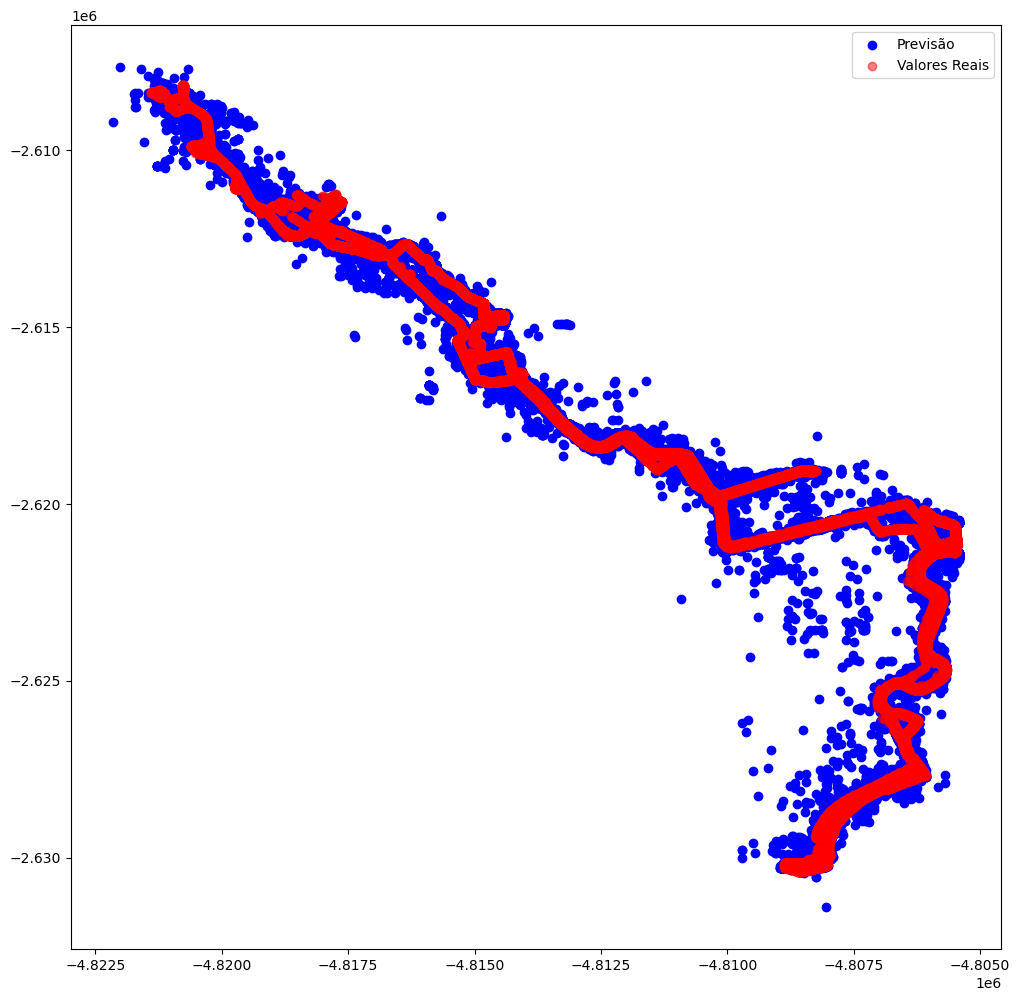

In [66]:
evaluate_position_prediction_pos(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(y_pred[:,0],y_pred[:,1], color='blue', label='Previsão')

ax.scatter(y_test['longitude'].values,y_test['latitude'].values, color='red', alpha=0.5, label='Valores Reais')

plt.legend()
plt.show()

Resultados minimamente validados

## TESTE DA PIPELINE DE DATAHORA

In [67]:
gdf_filtered = remove_outliers_grid(gdf,cell_size=100, min_points=50)
print(f"Número de pontos após o filtro por densidade: {len(gdf_filtered)}")
gdf_selection = encoding_features(gdf_filtered)

gdf_transf = extract_coords_as_num_date(gdf_selection)

X_train, y_train, X_test, y_test = split_test_task_pos(gdf_transf,target=['datahora_num'])
print(X_train.columns)


Número de pontos após o filtro por densidade: 1207547
Index(['velocidade', 'ordem_B31009', 'ordem_B31016', 'ordem_B31017',
       'ordem_B31020', 'ordem_B31028', 'ordem_B31031', 'ordem_B31032',
       'ordem_B31037', 'ordem_B31039',
       ...
       'hour', 'day_of_week', 'min', 'sec', 'month', 'lat_prev', 'lon_prev',
       'delta_lat', 'delta_lon', 'horas_desde_inicio'],
      dtype='object', length=116)


In [68]:
model = chunk_lgbm(X_train, y_train, batch_size=len(X_train))
X_test_scaled = model.scaler_X.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
y_pred_scaled = model.predict(X_test_scaled)
y_pred = model.scaler_y.inverse_transform(y_pred_scaled)

✅ Treinando com os últimos 965864 amostras (linhas 0 até 965864)
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 965864, number of used features: 114
[LightGBM] [Info] Start training from score 0.000000


In [69]:
y_pred_time = pd.to_datetime(y_pred.flatten(), unit='s')
y_pred_time

DatetimeIndex(['2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               '2024-05-07 15:28:40.894848347',
               ...
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 15:30:10.648205280',
               '2024-05-07 07:59:17.756250143',
               '2024-05-07 07:59:17.756250143',
               '2024-05-07 07:59:17.756250143'],
              dtype=

In [59]:
y_test['datahora'] = pd.to_datetime(y_test['datahora_num'], unit='s')

In [62]:
y_test

datahora_num            datahora
965966     1715096970 2024-05-07 15:49:30
965967     1715096970 2024-05-07 15:49:30
965968     1715096970 2024-05-07 15:49:30
965969     1715096970 2024-05-07 15:49:30
965970     1715096970 2024-05-07 15:49:30
...               ...                 ...
1207542    1715385597 2024-05-10 23:59:57
1207543    1715385597 2024-05-10 23:59:57
1207544    1715385628 2024-05-11 00:00:28
1207545    1715385628 2024-05-11 00:00:28
1207546    1715385628 2024-05-11 00:00:28

[241579 rows x 2 columns]

In [70]:
from sklearn.metrics import mean_absolute_error

# Calcular MAE em segundos
mae_seconds = mean_absolute_error(y_test['datahora_num'].values, y_pred)
print(f"MAE em segundos: {mae_seconds}")


MAE em segundos: 150809.07047164708


# Modelo da resposta

In [77]:
def apply_pipeline(test, beg_date, end_date, task_type):

	
	if 'latitude' in test.columns:
		test['latitude'] = test['latitude'].astype(str).str.replace(',', '.')
		test['latitude'] = pd.to_numeric(test['latitude'])
	if 'longitude' in test.columns:
		test['longitude'] =  test['longitude'].astype(str).str.replace(',', '.')
		test['longitude'] = pd.to_numeric(test['longitude'])

	gdf = select_data(beg_date, end_date)
	gdf_filtered = remove_outliers_grid(gdf,cell_size=100, min_points=50)
	print(f"Número de pontos após o filtro por densidade: {len(gdf_filtered)}")
	gdf_selection = encoding_features(gdf_filtered)

	gdf_transf = extract_coords_as_num_date(gdf_selection)

	df_test_transf = test.copy()
	if(task_type == 2):
		target = [ 'latitude', 'longitude']
	else:
		target = ['datahora_num']

	X_train, y_train = get_train(gdf_transf,target=target)
	X_test = get_test(df_test_transf, target=target)

	model = chunk_lgbm(X_train, y_train)
	X_test_scaled = model.scaler_X.transform(X_test)
	X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
	y_pred_scaled = model.predict(X_test_scaled)
	y_pred = model.scaler_y.inverse_transform(y_pred_scaled)
	
	return y_pred